In [1]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

from open_data  import matlab_file
from structure_data import  manage
from measures import ISI, FiringRate, tools
from classify import HistGrad

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms


import os
import sys

%load_ext autoreload
%autoreload 2

# Load and format data

### Load data

In [2]:
#Load
session, data_path, info_path = matlab_file.from_lab(lab_desktop=True, session='t150204001')
data, load_info = matlab_file.open(data_path)
session_info_raw = matlab_file.clean(info_path)


43 files loaded


In [3]:
# get sessions and units information (unit, prob, elitrials)
info_units,  info_session = manage.info(load_info, session_info_raw, session)
unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = manage.units_label(info_units)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(manage.elitrials)
# get unit's index without eli trials 
completeUnit = manage.CompleteTasktime(info_session, load_info, session)
unit_label[:5]

Complete unit found ! 
loading index = 2
matfile : t150204001_probe1_contact3_unit1.mat


['P1-23-2', 'P1-5-1', 'P1-3-1', 'P1-1-1', 'P2-6-1']

In [4]:
spike_times, task_times, target_info = matlab_file.extract_data(\
        load_info, data, target_keys_OFF=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'],\
        target_keys_ON=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], \
        event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

### Format spike times 

In [5]:
event_labels = matlab_file.get_event_labels(task_times)
event_times = matlab_file.get_event_times(task_times, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = manage.events_by_trial(event_times, event_labels)

In [6]:
unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {task_times[0][1].keys()}')


times as list : [3047992 3049069 3050391 3051713 3053021 3054320 3054799]
times as neo events : [3047992. 3049069. 3050391. 3051713. 3053021. 3054320. 3054799.] ms
spike train sample : [    237    2137    3267 ... 3657198 3657250 3658579]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time'])


In [7]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


### Format target

In [8]:
target = manage.target_by_trials(target_info, completeUnit)
target

,trial_type,position,type_and_pos
0,1,2,0
1,1,2,0
2,1,3,1
3,1,3,1
4,1,4,2
...,...,...,...
171,1,3,1
172,2,3,4
173,2,4,5
174,2,4,5


### Format trials

In [9]:
# align times by trials for each neurons
df_task_ts_by_neuron = manage.time_by_trials(df_task_ts_by_neuron, df_task_ts, event_labels)
df_task_ts_by_neuron[0][1]

# split the spike time vector by trial
spk_trials, spike_train_trial = manage.spike_ts_by_trial(trials_ts, spike_times)
spikes_times_aligned = manage.spike_ts_aligned(df_task_ts, df_task_ts_by_neuron, spike_times, unit_label, spike_train_trial)

/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:360: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start = data.iloc[idx_trial_valid][1]
/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:361: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stop = data.iloc[idx_trial_valid][-1]
/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:383: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

# Raster plot

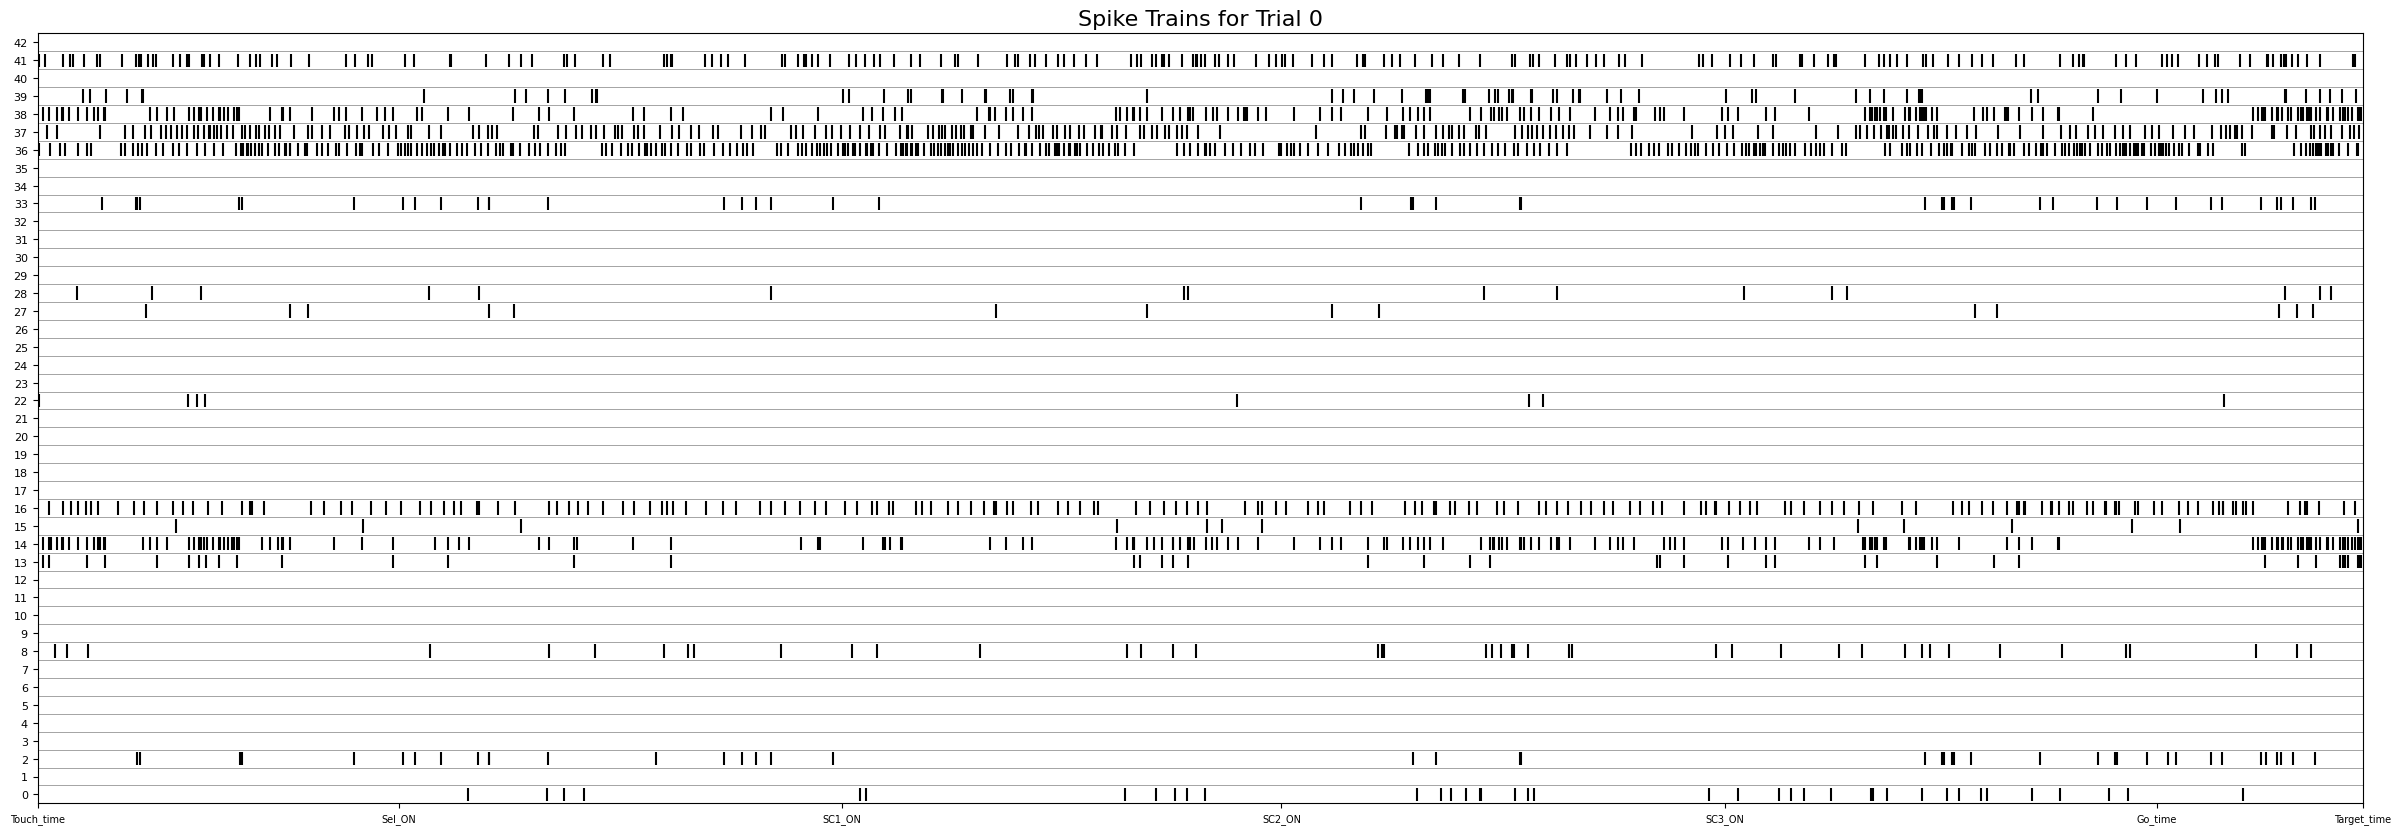

In [10]:
n_neurons = spikes_times_aligned.shape[0]

t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(30, 10))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# Compute measure

## Instantaneous Firing rate 

In [11]:
sigma = [100]

max_length = tools.get_max_length_trials(spikes_times_aligned[completeUnit])
spikes_binarized = FiringRate.binarize_spike_times(spikes_times_aligned, max_length)
spike_convolved = FiringRate.convolve_spike_binarized(spikes_binarized, sigma)

## Paiwise synchrony

In [12]:
row, col = np.triu_indices(n_neurons, k=1)
n_pairs = len(row)
list_pairs = np.zeros((n_pairs,3), dtype='int')

for n_p, (r,c) in enumerate(zip(row, col)):
    list_pairs[n_p, 0] =  r
    list_pairs[n_p, 1] =  c
    list_pairs[n_p, 2] =  n_p

In [13]:
n_trials, n_times, n_neurons = spike_convolved.shape
Synch = np.zeros((n_trials, n_times, n_pairs))


for t in range(n_trials) :     
    for n_p, (r,c) in enumerate(zip(row, col)):
        Synch[t,:,n_p] = spike_convolved[t, :, r] * spike_convolved[t, :, c]

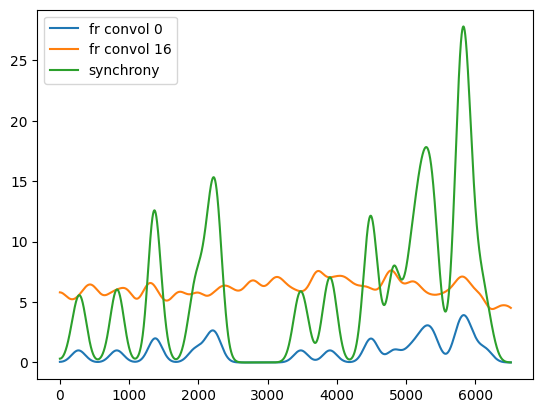

In [14]:
n0 = 0
n1 = 16 
neurons_ = [n0,n1]
pair = list_pairs[np.logical_and(list_pairs[:,0] == n0, list_pairs[:,1] == n1)][0][2]
plt.plot(spike_convolved[121,:,n0], label=f'fr convol {n0}')
plt.plot(spike_convolved[121,:,n1], label=f'fr convol {n1}')
plt.plot(Synch[121,:,pair], label='synchrony')
plt.legend()

## ISI Distance

In [15]:
X_isi_ = np.zeros((n_trials), dtype=object)
ISI_distance = []
X_isi = []

for t in range(n_trials) : 
    n_times = spikes_times_aligned[0][t]['t_stop_aligned']
    X_isi_one_trial = np.zeros((n_neurons, n_times))
    for n in range(n_neurons) :
        x_isi = ISI.compute(spikes_times_aligned[n][t]) 
        X_isi_one_trial[n, :] = x_isi

    ISI_distance_one_trials = np.zeros((n_pairs, n_times))
    for n_p, (r,c) in enumerate(zip(row, col)):
        ISI_distance_one_trials[n_p,:] = ISI.distance(X_isi_one_trial[r, :], X_isi_one_trial[c, :])
    
    X_isi.append(X_isi_one_trial)
    ISI_distance.append(ISI_distance_one_trials)

In [16]:
max_length, time = tools.get_max_length_ISI(n_trials, ISI_distance)
ISI_distance_interp = np.zeros((n_trials, max_length, n_pairs), dtype=np.float32)
X_isi_interp = np.zeros((n_trials, max_length, n_neurons), dtype=np.float32)


for t in range(n_trials):
        for p in range(n_pairs):
                ISI_distance_interp[t, :, p]  = ISI.interpolate_ISI_distance(ISI_distance[t][p], max_length)
        for n in range(n_neurons) : 
                X_isi_interp[t, :, n] = ISI.interpolate_X_isi(X_isi[t][n], max_length)
        

# Plot measure

7304
(176, 7304, 43)
(176, 7304, 43)


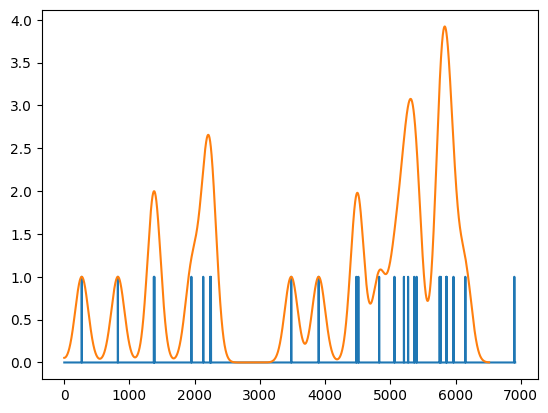

In [18]:
print(max_length)
print(spikes_binarized.shape)
print(spike_convolved.shape)
plt.plot(spikes_binarized[121,:,0])
plt.plot(spike_convolved[121,:,0])

In [19]:
n0 = 0
n1 = 16 
neurons_ = [n0,n1]
pair = list_pairs[np.logical_and(list_pairs[:,0] == n0, list_pairs[:,1] == n1)][0][2]
plt.plot(spike_convolved[121,:,n0,2], label=f'fr convol {n0}')
plt.plot(spike_convolved[121,:,n1,2], label=f'fr convol {n1}')
plt.plot(Synch[121,:,pair], label='synchrony')
plt.legend()

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

(-500.0, 7804.0)

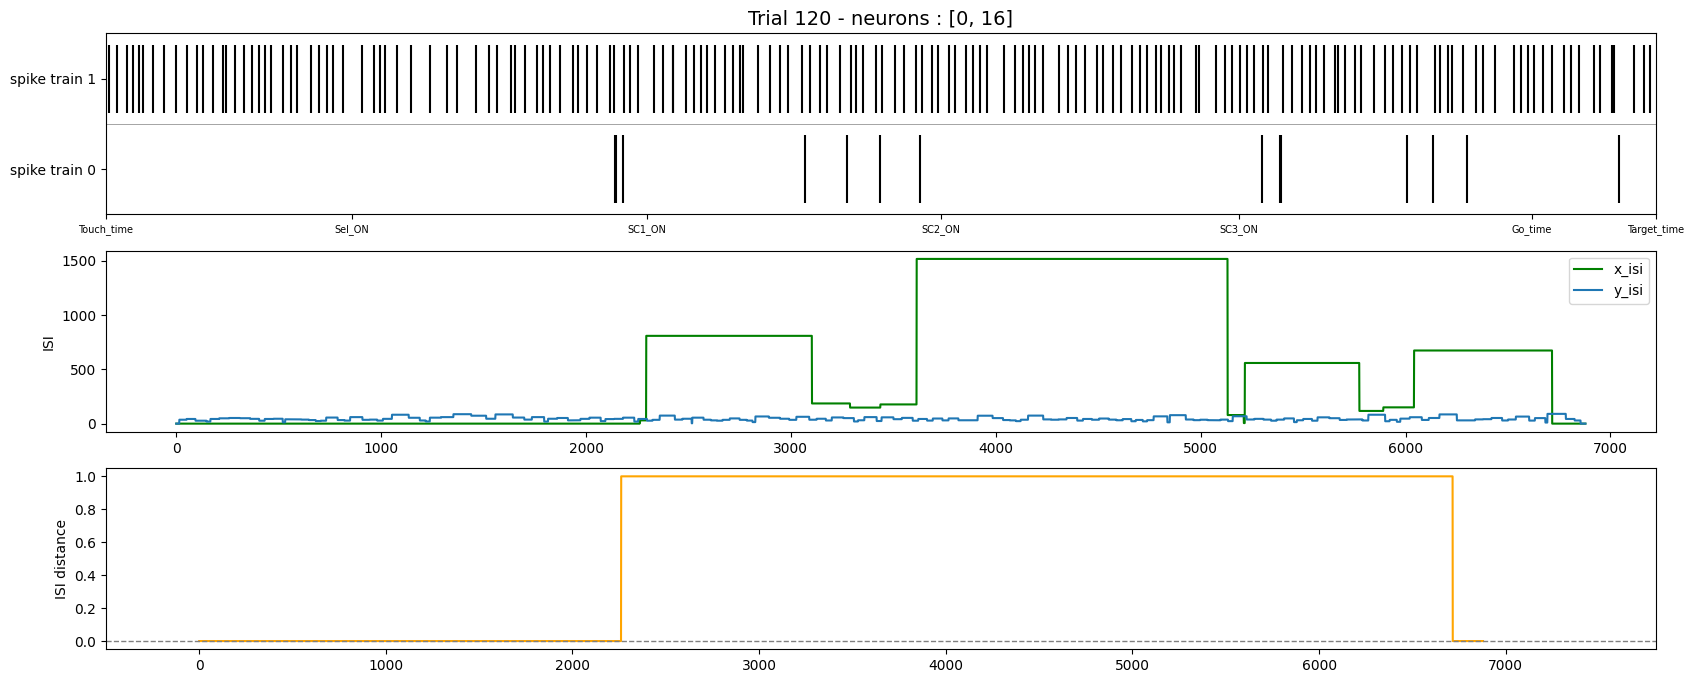

In [20]:
t = 120
neurons_ = [0,16]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))
# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()
0
# Plot isi_dist in the second column
axs[2].plot(ISI_distance_interp[t,:,0], color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_interp[t,:,0].shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_interp[t,:,0].shape[0] + 500)  # Set x-axis limits



# Classif 

In [21]:
n_times = list(np.arange(0, ISI_distance_interp.shape[1], 100))
n_bins = len(n_times)

# Initialiser une liste vide pour stocker les moyennes de bin
list_mean = {'FR'  : [],
            'Synch' : [],
            'ISI': []}

list_data = {'FR' : spike_convolved,
            'Synch': Synch,
            'ISI': ISI_distance_interp}

# Calculer la moyenne sur l'axe des temps
for key, data in list_data.items():
    # Calculer les moyennes pour chaque bin et chaque paire
    for start, end in zip(n_times[:-1], n_times[1:]):
        # Extraire les données pour le bin actuel
        bin_data = data[:, start:end, :]
        # Calculer la moyenne sur l'axe des temps
        bin_mean = np.nanmean(bin_data, axis=1)
        # Convertir les moyennes en DataFrame et les ajouter à la liste
        bin_mean_df = pd.DataFrame(bin_mean)
        list_mean[key].append(bin_mean_df)

/tmp/ipykernel_8195/3758335856.py:20: RuntimeWarning: Mean of empty slice
  bin_mean = np.nanmean(bin_data, axis=1)


In [64]:
# Build pipeline
n_splits = 2
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
# Standardisation scheme
scaler = StandardScaler()
# Algo
estimator = HistGradientBoostingClassifier(max_iter=5, max_depth=10, max_bins=10)
clf = make_pipeline(scaler, estimator)

In [65]:
list_models = {'FR'  : [],
            'Synch' : [],
            'ISI': []}
for key, data in list_mean.items():
    for idx, t in enumerate(n_times[:-1]):
        model = HistGrad.Model_info(n_splits=n_splits, n_events=n_bins, \
        data=data[idx], cvs=cvs0, clf=clf)
        
        list_models[key].append(model)

In [66]:
                    
acc_df = HistGrad.run(list_models, target, n_times)

#################
SPLIT : 0
##################
FR


/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/classify/HistGrad.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  acc_df = pd.concat((acc_df, pd.DataFrame(data=d)))
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_va

Synch


/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/IN

ISI
#################
SPLIT : 1
##################
FR
Synch
ISI


In [67]:
acc_df

,split,data_type,measure,time,target_type,accuracy,y_true,y_pred
0,0,test,FR,0,trial_type,0.694444,"[3, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 1, 1, 1, 3, ...","[3, 3, 1, 3, 1, 2, 3, 3, 1, 1, 3, 1, 1, 1, 3, ..."
1,0,shuff,FR,0,trial_type,0.472222,"[3, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 1, 1, 1, 3, ...","[3, 3, 1, 3, 1, 2, 3, 3, 1, 1, 3, 1, 1, 1, 3, ..."
2,0,test,FR,0,position,0.277778,"[2, 3, 4, 2, 2, 3, 3, 4, 2, 3, 4, 4, 3, 2, 4, ...","[4, 4, 2, 4, 2, 4, 4, 4, 4, 3, 4, 2, 4, 4, 2, ..."
3,0,shuff,FR,0,position,0.277778,"[2, 3, 4, 2, 2, 3, 3, 4, 2, 3, 4, 4, 3, 2, 4, ...","[4, 4, 2, 4, 2, 4, 4, 4, 4, 3, 4, 2, 4, 4, 2, ..."
4,0,test,FR,0,type_and_pos,0.111111,"[6, 7, 5, 6, 3, 7, 7, 8, 3, 4, 8, 2, 1, 0, 8, ...","[6, 2, 0, 6, 0, 5, 8, 2, 0, 2, 7, 0, 0, 1, 6, ..."
...,...,...,...,...,...,...,...,...
2623,1,shuff,ISI,7200,trial_type,0.416667,"[3, 3, 1, 3, 1, 1, 1, 3, 2, 2, 2, 3, 2, 3, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2624,1,test,ISI,7200,position,0.194444,"[3, 2, 4, 4, 4, 4, 4, 3, 3, 4, 2, 2, 4, 4, 4, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2625,1,shuff,ISI,7200,position,0.194444,"[3, 2, 4, 4, 4, 4, 4, 3, 3, 4, 2, 2, 4, 4, 4, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2626,1,test,ISI,7200,type_and_pos,0.055556,"[7, 6, 2, 8, 2, 2, 2, 7, 4, 5, 3, 6, 5, 8, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


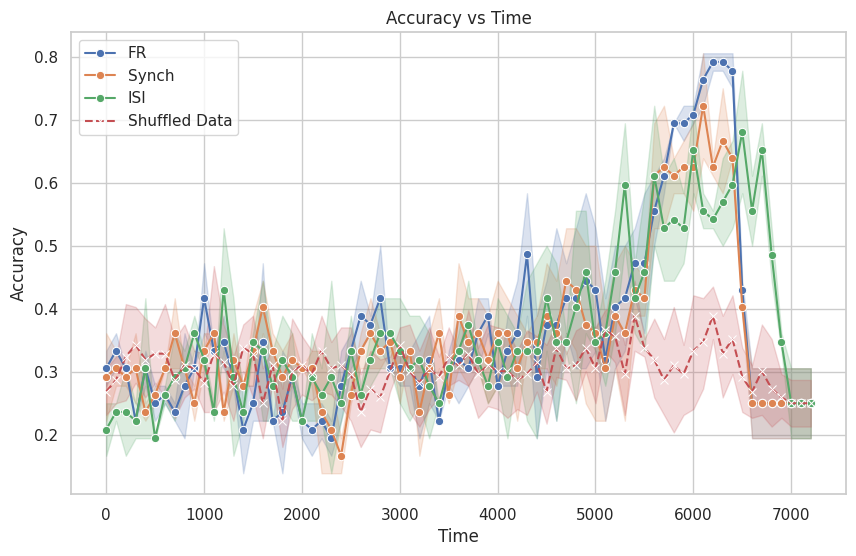

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Séparez les données par type
test_data = acc_df[(acc_df['data_type'] == 'test') & (acc_df['target_type'] == 'position')]
shuff_data = acc_df[(acc_df['data_type'] == 'shuff') & (acc_df['target_type'] == 'position')]

# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les données
plt.figure(figsize=(10, 6))

# Tracer les données de test
sns.lineplot(data=test_data, x='time', y='accuracy', hue='measure', marker='o', linestyle='-')

# Tracer les données de shuffled
sns.lineplot(data=shuff_data, x='time', y='accuracy', marker='x', linestyle='--', label='Shuffled Data')

# Définir les étiquettes d'axe et le titre
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Time')

# Afficher la légende
plt.legend()

# Afficher le tracé
plt.show()
